In [ ]:
import os
os.chdir('..')

In [27]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from scipy import spatial
import math
from pathlib import Path
import cv2

### Data Preprocessing

In [3]:
labels = np.load('data/embeddings.labels.npy')
embeddings = np.load('data/embeddings.npy')
filepaths = np.load('data/embeddings.filepaths.npy')

In [4]:
# total classes
len(set(labels))

102

In [5]:
def train_test_split_modified(embeddings, labels, test_size_per_class=20):
    test_indexes = []
    train_indexes = []
    random = np.random.RandomState(2021)
    for label in sorted(set(labels)):
        idx, = np.where(labels==label)
        test_idx_for_class = random.choice(idx, test_size_per_class, replace=False)
        train_idx_for_class = set(idx).difference(test_idx_for_class)
        test_indexes.extend(test_idx_for_class)
        train_indexes.extend(train_idx_for_class)
    assert len(train_indexes) + len(test_indexes) == len(embeddings) == len(labels)
    return embeddings[train_indexes], embeddings[test_indexes], labels[train_indexes], labels[test_indexes], train_indexes, test_indexes

In [6]:
X_train, X_test, y_train, y_test, train_indexes, test_indexes = train_test_split_modified(embeddings, labels)

In [7]:
pd.value_counts(y_test)

gerenuk          20
flamingo_head    20
Faces_easy       20
metronome        20
llama            20
                 ..
elephant         20
helicopter       20
mayfly           20
bass             20
okapi            20
Length: 102, dtype: int64

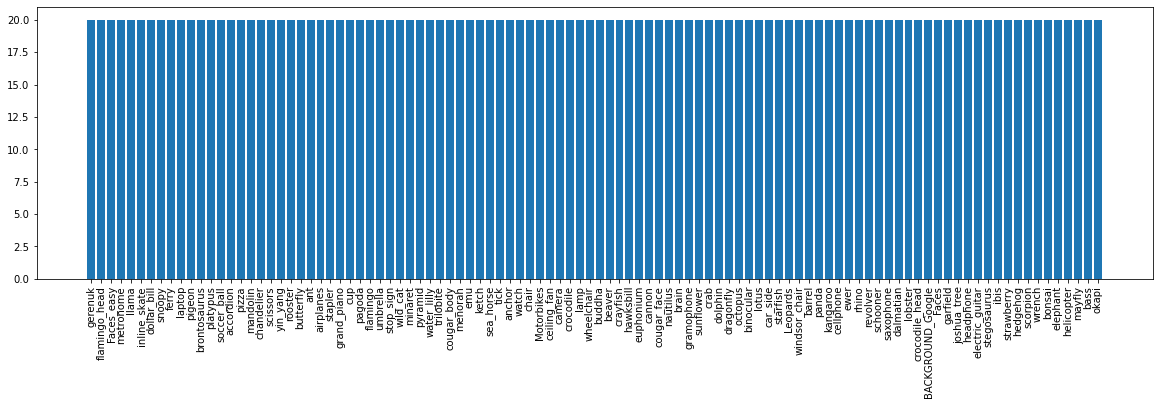

In [68]:
plt.figure(figsize=(20,5))
plt.bar(pd.value_counts(y_test).index, pd.value_counts(y_test).values)
plt.xticks(rotation=90)
plt.show()

In [10]:
filepaths_test = filepaths[test_indexes]
X_candidates, X_queries, y_candidates, y_queries, candidate_idx, queries_idx = train_test_split_modified(X_test, y_test, test_size_per_class=5)

In [29]:
filepaths_candidates = filepaths_test[candidate_idx]
filepaths_queries = filepaths_test[queries_idx]

In [12]:
pd.value_counts(y_candidates)

gerenuk          15
flamingo_head    15
Faces_easy       15
metronome        15
llama            15
                 ..
elephant         15
helicopter       15
mayfly           15
bass             15
okapi            15
Length: 102, dtype: int64

In [13]:
pd.value_counts(y_queries)

gerenuk        5
pizza          5
soccer_ball    5
wild_cat       5
ferry          5
              ..
elephant       5
helicopter     5
mayfly         5
bass           5
okapi          5
Length: 102, dtype: int64

In [14]:

def calculate_cosine_distance(a, b):
    cosine_distance = float(spatial.distance.cosine(a, b))
    return cosine_distance


def calculate_cosine_similarity(a, b):
    cosine_similarity = 1 - calculate_cosine_distance(a, b)
    return cosine_similarity

### Generating Metrics

In [16]:
def precision_at_k(relevance_mask):
    return sum(relevance_mask)/len(relevance_mask)

def average_precision_at_k(relevance_mask):
    total = 0
    for i in range(len(relevance_mask)):
        if relevance_mask[i]>0:
            total += sum(relevance_mask[:i+1])/(i+1)
    return total / len(relevance_mask)

In [17]:
class Baseline1:
    def __init__(self, random_seed=2021,):
        self.random_seed=random_seed
    
    def fit(self, X_train, y_train):
        pass
    
    def metric(self, X_queries, y_queries, X_candidates, y_candidates, k, scorer=precision_at_k):
        total = 0
        n = 0
        random = np.random.RandomState(self.random_seed)
        for each_query in y_queries:
            relevance_mask = random.choice(y_candidates, k, replace=False)==each_query
            total += scorer(relevance_mask)
            n+= 1
        return total/n  # mean precision at K

In [18]:
model = Baseline1(random_seed=2021)

In [19]:
model.metric(X_queries, y_queries, X_candidates, y_candidates, k=10, scorer=precision_at_k)

0.008823529411764706

In [20]:
model.metric(X_queries, y_queries, X_candidates, y_candidates, k=10, scorer=average_precision_at_k)

0.003178493619670091

In [21]:
class Baseline2:
    def __init__(self, random_seed=2021,):
        self.random_seed=random_seed
    
    def fit(self, X_train, y_train):
        pass
    
    def rank_top_k(self, x, X_candidates, y_candidates, k):
        # x of size n, X_candidates pxn, y_candidates of size pxn
        distances = list(map(lambda x_c: calculate_cosine_distance(x, x_c), X_candidates))
        indexes = np.argsort(distances)[:k]
        return y_candidates[indexes]
    
    def metric(self, X_queries, y_queries, X_candidates, y_candidates, k, scorer=precision_at_k):
        total = 0
        n = 0
        random = np.random.RandomState(self.random_seed)
        for x_query, y_query in zip(X_queries, y_queries):
            relevance_mask = self.rank_top_k(x_query, X_candidates, y_candidates, k)==y_query
            total += scorer(relevance_mask)
            n+= 1
        return total/n  # mean precision at K

In [22]:
model = Baseline2(random_seed=2021)

In [23]:
model.metric(X_queries, y_queries, X_candidates, y_candidates, k=10, scorer=precision_at_k)

0.6947058823529408

In [24]:
model.metric(X_queries, y_queries, X_candidates, y_candidates, k=10, scorer=average_precision_at_k)

0.6416111889200122

### Qualitative Results

In [28]:
### Helper function for grid plot

def read_image(image_path: Path):
    """
    Returns image in RGB format
    """
    img = cv2.imread(str(image_path))
    if img is not None:
        img = img[:, :, ::-1]
    return img

In [66]:
random = np.random.RandomState(2021)
query_indexes = random.choice(np.arange(len(X_queries)), 5, replace=False)

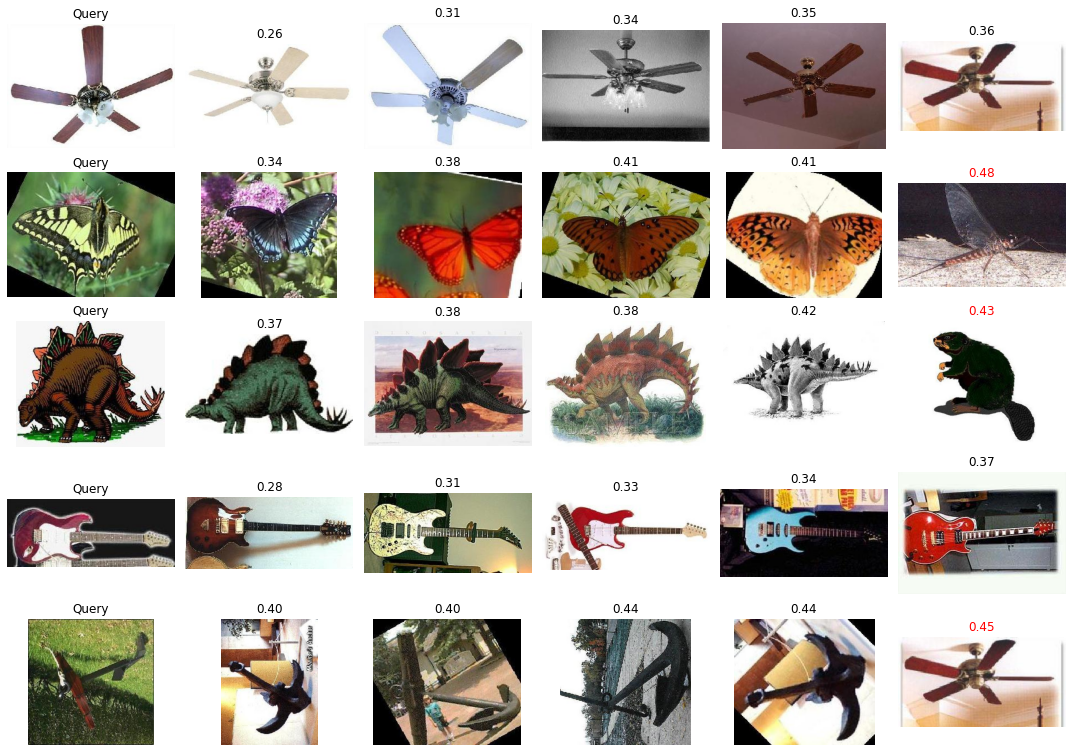

In [67]:
fig, axarr = plt.subplots(5,6, figsize=(10*1.5,7*1.5))
for i, (query, label, query_filepath) in enumerate(zip(X_queries[query_indexes], y_queries[query_indexes], filepaths_queries[query_indexes])):
    axarr[i,0].imshow(read_image(query_filepath))
    axarr[i,0].set_title('Query')

    axarr[i,0].axis('off')
    
    # getting solutions
    distances = list(map(lambda x_c: calculate_cosine_distance(query, x_c), X_candidates))
    indexes = np.argsort(distances)[:5]
    for j, idx in enumerate(indexes):
        result_filepath = filepaths_candidates[idx]
        axarr[i,j+1].imshow(read_image(result_filepath))
        axarr[i,j+1].axis('off')
        fontdict = {'color': 'red'} if label != y_candidates[idx] else {}
        axarr[i,j+1].set_title(f"{distances[idx]:0.2f}", fontdict=fontdict)
        
plt.tight_layout()
plt.savefig('images/result.png')